In [1]:
USE_DE=True
USE_PE=False
COLAB=False

#  Imports

In [2]:
import pathlib
import os
import re
import string
from unicodedata import normalize
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt



from de_data import DataGen
from positional_encoding import encode_pos_sin_cosine, PositionalEmbedding
# from self_attention  import SelfAttention
# from mha import MultiHeadAttention
# from add_norm import AddNorm
from positionwise_ff import FeedForward
# from encoder_layer import EncoderLayer
# from transformer_encoder import TransformerEncoder
# from decoder_layer import DecoderLayer
# from transformer_decoder import TransformerDecoder
# from transformer_model import TransformerModel
from lr_schedular import  CustomSchedule, MyCustomSchedule
from masked_loss_accu import loss_function, accuracy_function
from training_loop import start_training



import warnings

# Suppress TensorFlow logging (1=filter INFO, 2=filter INFO and WARNING)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Suppress Python warnings
warnings.filterwarnings('ignore')

import time
import random
random.seed(42)
from random import randint
if COLAB:
 from google.colab import drive
if USE_PE:
  import tensorflow_datasets as tfds
  import tensorflow_text
from pathlib import Path
import pathlib
import scipy
import numpy as np
np.random.seed(123)
import tensorflow as tf
tf.random.set_seed(42)
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.layers import (
    Input,  Dense, 
    Concatenate, RepeatVector,
    Lambda, Layer,  Embedding, Bidirectional,
    Dot, LayerNormalization, Dropout)
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

2024-03-29 16:57:07.203155: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-29 16:57:07.218082: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-29 16:57:07.220594: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-29 16:57:07.251629: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-29 16:57:12.214929: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [3]:
print(tf.__version__)

2.16.1


# Colab or local

In [4]:
if COLAB:
  drive.mount('/content/drive')
  fpath = '/content/drive/My Drive/writeups/notebooks/deu.txt'
  # Check if the file exists
  fpath1 = Path(fpath)
  if fpath1.exists():
      print("File exists.")
  else:
      print("File does not exist.")
else:
  fpath='/mnt/c/Users/Bhujay_ROG/My Drive/writeups/notebooks/deu.txt'

# Generate Data  DE

In [5]:
n_sentences = 500
datagen = DataGen(fpath=fpath)
if USE_DE:
    # datagen = DataGen(fpath='/mnt/c/Users/Bhujay_ROG/My Drive/writeups/notebooks/deu.txt')
    dataset, lang1, lang2 = datagen.get_cleaned_delimited_data_as_array()
    X1, X2, y, lang1_tokenizer, lang2_tokenizer, en_vocab_size, de_vocab_size, en_seq_len, de_seq_len = \
        datagen.get_source_target_data_n_tokenizer(n_sentences=n_sentences, from_end=True)
example_data_x1 = X1[:2]
example_data_x2 = X2[:2]

195847
['Hi.', 'Grüß Gott!']
[INFO] Total dataset size:  (195847, 2)
[hi] => [hallo]
[hi] => [gru gott]
[run] => [lauf]
[wow] => [potzdonner]
[wow] => [donnerwetter]
[fire] => [feuer]
[help] => [hilfe]
[help] => [zu hulf]
[stop] => [stopp]
[wait] => [warte]
[INFO] Total dataset size: 40000
['tom came outside' 'sos tom kam nach drauen eos']
(40000, 2)
(40000,)
tom came outside
195847
['Hi.', 'Grüß Gott!']
[INFO] Total dataset size:  (195847, 2)
[hi] => [hallo]
[hi] => [gru gott]
[run] => [lauf]
[wow] => [potzdonner]
[wow] => [donnerwetter]
[fire] => [feuer]
[help] => [hilfe]
[help] => [zu hulf]
[stop] => [stopp]
[wait] => [warte]
[INFO] Total dataset size: 500
['tom was staring at mary who was sitting on the school bus that was parked in front of the school'
 'sos tom stierte maria an die in dem schulbus sa der vor der schule parkte eos']
(500, 2)
(500,)
tom was staring at mary who was sitting on the school bus that was parked in front of the school
encoder input:
 [[1222 1223    8    1

# Positional Encoding

## PE function

exponent_i:  (512,)
denominator scalar:  512.0
angle_rates: (512,)
angle_rads: (2048, 512)
sine_values_even: (2048, 256)
cosine_values_odd: (2048, 256)
sin_plus_cos_interleaved: (2048, 512)


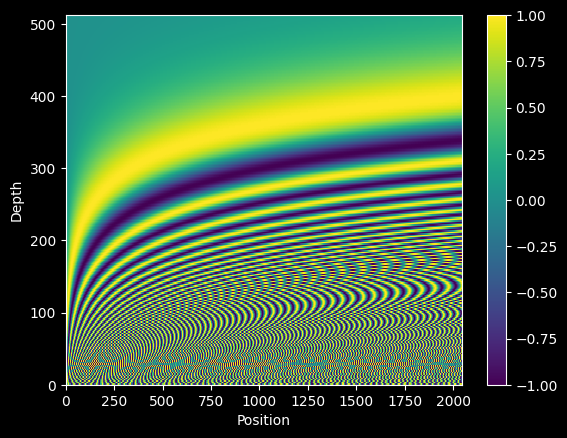

In [6]:
positional_encodings = encode_pos_sin_cosine(2048, 512, debug=True)
plt.style.use('dark_background')
plt.pcolormesh(positional_encodings.T)
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

## PE class

In [7]:
d_model=512
pos_embedding = PositionalEmbedding(en_vocab_size, d_model)
embedded_data = pos_embedding(example_data_x1, training=False)
print('embedded_data shape:', embedded_data.shape)
# print('embedded_data shape:', embedded_data[0][3])
print('embedded_data mask', embedded_data._keras_mask)

embedded_data shape: (2, 101, 512)
embedded_data mask tf.Tensor(
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True False False False False False
  False False False False False False False False False False False False
  False False 

# Attention Classes

## Testing MHA masks 

In [8]:
layer = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=2)
x, s = layer(embedded_data, embedded_data, return_attention_scores=True)
print(x)
print(s)

tf.Tensor(
[[[ 2.2337688e-03 -3.0533705e-04  4.7402964e-03 ...  1.1020283e-03
    4.2954083e-03  2.5706599e-03]
  [ 3.4827930e-03 -9.9117879e-04  3.7643488e-03 ...  4.3567145e-04
    3.7247355e-03  1.8140228e-03]
  [ 7.0289511e-04  5.8104109e-04  5.9400499e-03 ...  1.5967219e-03
    5.0847800e-03  3.5944975e-03]
  ...
  [-4.6341377e-03  4.0217698e-02  1.1205485e-02 ...  2.0136762e-02
   -5.2617051e-02  3.1736754e-02]
  [-4.6341377e-03  4.0217698e-02  1.1205485e-02 ...  2.0136762e-02
   -5.2617051e-02  3.1736754e-02]
  [-4.6341377e-03  4.0217698e-02  1.1205485e-02 ...  2.0136762e-02
   -5.2617051e-02  3.1736754e-02]]

 [[-6.1426312e-03  1.7640991e-03 -1.0639527e-02 ... -5.4696817e-03
   -9.1463216e-03 -4.5689931e-03]
  [-1.7985785e-03  6.0630566e-05 -7.7593117e-03 ... -5.2249050e-03
   -5.8432459e-03 -3.6242849e-03]
  [-6.2910700e-03  4.7343338e-04 -1.1724654e-02 ... -5.7852594e-03
   -8.3096940e-03 -6.1029489e-03]
  ...
  [-5.4025771e-03  3.4170981e-02  5.5346829e-03 ...  1.5253182e-02

###  why masked  score of rows are not zero 

considering this elements in the weight matrix  as $w_{11}$ to $w_{nn}$  
and $v_{11}$ to $v_{nd_{v}}$ as the elements in value matrix. 
The result for the first  row of w and first col of the v are this:
$w_{11}v_{11}+w_{12}v_{21}+w_{13}v_{31}+w_{14}v_{41}$ 

$v_{31}$  and $v_{41}$ will be set to zero due to the zero weight $w_{13}$ and $w_{14}$
 



##  Base Attention class MHA with add and norm

In [9]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()
    self.supports_masking = True

## Global Self Attention class

###  implicit attention mask

In [10]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x, return_attention_scores=False):   
    mhaout = self.mha(
        query=x,
        value=x,
        key=x,        
        return_attention_scores=return_attention_scores)
    if return_attention_scores:
        attn_output, attn_scores = mhaout
        self.last_attn_scores = attn_scores 
    else:
        attn_output = mhaout
    x = self.add([x, attn_output])
    x = self.layernorm(x)       
    return x      

### Testing

In [11]:
print('shape of input data:', embedded_data.shape)
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512,)
gsa_out = sample_gsa(embedded_data, return_attention_scores=True )
print('without mask:', gsa_out)
print('attn_score:', sample_gsa.last_attn_scores)
print()

shape of input data: (2, 101, 512)
without mask: tf.Tensor(
[[[-1.2152966   0.4875395   0.58648014 ...  0.3936963   0.67973614
    0.47417888]
  [ 0.99262464 -1.5544646  -0.7790817  ... -1.3435932  -0.9428211
    1.353523  ]
  [-1.430133   -0.88548523 -0.25506437 ... -1.3293511   1.085522
   -0.48658997]
  ...
  [ 1.2778958   0.56121206 -0.47179326 ...  1.6584709  -0.73717856
    0.87458074]
  [ 1.2778958   0.56121206 -0.47179326 ...  1.6584709  -0.73717856
    0.87458074]
  [ 1.2778958   0.56121206 -0.47179326 ...  1.6584709  -0.73717856
    0.87458074]]

 [[ 0.5375125  -0.818417   -1.581938   ...  0.5587921   0.10925007
    0.7622851 ]
  [-0.28043267  1.294878   -1.6773641  ... -0.52893555 -0.69965863
   -1.6105003 ]
  [ 1.7555408  -0.36321747 -0.08850935 ... -0.60465395  0.19669396
    1.69413   ]
  ...
  [ 1.2783959   0.55870366 -0.4670283  ...  1.6468669  -0.7339127
    0.88558793]
  [ 1.2783959   0.55870366 -0.4670283  ...  1.6468669  -0.7339127
    0.88558793]
  [ 1.2783959   0.

#### Explicit attention mask 

In [12]:
class GlobalSelfAttention1(BaseAttention):
  def call(self, x, attention_mask=None, return_attention_scores=False):
    print('mask received:', attention_mask)
    attn_output, attn_scores = self.mha(
        query=x,
        value=x,
        key=x,
        attention_mask=attention_mask,
        return_attention_scores=return_attention_scores)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    self.last_attn_scores = attn_scores    
    return x      

In [13]:
# print('shape of input data:', embedded_data.shape)
# sample_gsa = GlobalSelfAttention1(num_heads=2, 
#                                              key_dim=512,
#                                              )
# x = sample_gsa(embedded_data, return_attention_scores=True )
# print('without mask:', x)
# # print('attn_score:', attn_score)
# print('attn_score:', sample_gsa.last_attn_scores)
# print()
# x =  sample_gsa(embedded_data, 
#            attention_mask=embedded_data._keras_mask,
#            return_attention_scores=True)

# print('without mask:', x)
# print('attn_score:', sample_gsa.last_attn_scores)

## CausalSelfAttention

In [14]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask=True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    # self.last_attn_scores = attn_scores
    return x

## testing causal attention

In [15]:
csa = CausalSelfAttention(num_heads=2, key_dim=512)
embedded_data_x2 = pos_embedding(X2[:2], training=False)
print('embedded_data_x2:', embedded_data_x2.shape)
csa_out =csa(embedded_data_x2) 
# print(en_emb.shape)
print('csa_out:', csa_out.shape)

embedded_data_x2: (2, 76, 512)
csa_out: (2, 76, 512)


####  testingn the masking effect 

In [16]:
embedded_data_x2_sliced = pos_embedding(X2[:2][:, :3], training=False)  ### taking three sequence
print('embedded_data_x2_sliced:', embedded_data_x2_sliced.shape)
out1 = csa(embedded_data_x2_sliced) ### output of the three sequence
print('shape of out1:', out1.shape)
out2 = csa(embedded_data_x2)
print('shape of out2:', out2.shape)
out2 = out2[:, :3]  ### sliced 3 sequence  after the output  
tf.reduce_max(abs(out1 - out2)).numpy()  # no difference in output  2.3841858e-07 = 0.00000023841858

embedded_data_x2_sliced: (2, 3, 512)
shape of out1: (2, 3, 512)
shape of out2: (2, 76, 512)


2.3841858e-07

## Cross Attention class

In [17]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)   
    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

###  Testing

In [18]:
cross_attention = CrossAttention(num_heads=2, key_dim=512)
cross_out = cross_attention(csa_out, gsa_out)
print(cross_out.shape)
print(cross_attention.last_attn_scores.shape)

(2, 76, 512)
(2, 2, 76, 101)


# class FeedForward

In [19]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    return x

###  testing ff

In [20]:
ffn = FeedForward(512, 2048)
ffn_out = ffn(gsa_out)
print('gsa_out:', gsa_out.shape)

gsa_out: (2, 101, 512)


#  Encoder Layer


In [21]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)
    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

#### testing encoder layer

In [22]:
encoder_layer = EncoderLayer(
    d_model=512, num_heads=8, dff=2048)
print(embedded_data.shape)
en_layer_out = encoder_layer(embedded_data)
print(en_layer_out.shape)

(2, 101, 512)
(2, 101, 512)


# Transformer Encoder

In [23]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()
    self.d_model = d_model
    self.num_layers = num_layers
    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)
    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.
    x = self.dropout(x)
    for i in range(self.num_layers):
      x = self.enc_layers[i](x)
    return x  # Shape `(batch_size, seq_len, d_model)`.

### testing encoder

In [24]:
encoder = Encoder(num_layers=1, d_model=512, num_heads=8, 
                  dff=2048, vocab_size=en_vocab_size) 
encoder_out = encoder(X1[:2], training=False)
print('input data:', X1[:2].shape)
print('encoder_out:', encoder_out.shape)

input data: (2, 101)
encoder_out: (2, 101, 512)


# Decoder Layer

In [25]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)
    
    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)
    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores
    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

#### Testing Decoder Layer class

In [26]:
decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

decoder_layer_out = decoder_layer(
    x=embedded_data_x2, context=encoder_out)

print('embedded_data_x2:',embedded_data_x2.shape)
print('encoder_out:', encoder_out.shape)
print('decoder_layer_out:', decoder_layer_out.shape) 

embedded_data_x2: (2, 76, 512)
encoder_out: (2, 101, 512)
decoder_layer_out: (2, 76, 512)


# Transformer Decoder 

In [27]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

#### Testing Decoder class

In [28]:
decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=de_vocab_size)

decoder_out = decoder(
    x=X2[:2], context=encoder_out)

print('X2 data:',X2[:2].shape)
print('encoder_out:', encoder_out.shape)
print('decoder_layer_out:', decoder_out.shape) 

X2 data: (2, 76)
encoder_out: (2, 101, 512)
decoder_layer_out: (2, 76, 512)


#  Transformer

In [29]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)
    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)
    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs
    context = self.encoder(context)  # (batch_size, context_len, d_model)
    x = self.decoder(x, context)  # (batch_size, target_len, d_model)
    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)
    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass
    # Return the final output and the attention weights.
    return logits


  @tf.function(input_signature=[
      tf.TensorSpec(shape=[None, None], dtype=tf.int32, name='input'),
      tf.TensorSpec(shape=[None, None], dtype=tf.int32, name='target')])
  def serve(self, input, target):
    # Assume `input` is your input sequence and `target` is the starting token for decoding
    # You may need to adjust this logic based on your specific needs
    predictions = self([input, target], training=False)
    return predictions

### Testing Transformer class

In [30]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=en_vocab_size,
    target_vocab_size=de_vocab_size,
    dropout_rate=dropout_rate)
output = transformer((X1[:2], X2[:2]))

print(X1[:2].shape)
print(X2[:2].shape)
print(output.shape)
idx=2
output = transformer((X1[idx:idx+1], X2[idx:idx+1]))
predicted_id = tf.argmax(output[:, :, :], axis=-1)
print('predicted_id:',  predicted_id)
print()
print('label:', y[idx:idx+1])

(2, 101)
(2, 76)
(2, 76, 2772)
predicted_id: tf.Tensor(
[[1000 1491 2292 1080 1569  830 1264 2725  925 1599 1599  432 1839 1234
   817 1295  971 2598 1080 1080 1080 1080 1080 1080 1080 1080 1080 1080
  1080 1080 1080 1080 1080 1080 1080 1080 1080 1080 1080 1080 1080 1080
  1080 1080 1080 1080 1080 1080 1080 1080 1080 1080 1080 1080 1080 1080
  1080 1080 1080 1080 1080 1080 1080 1080 1080 1080 1080 1080 1080 1080
  1080 1080 1080 1080 1080 1080]], shape=(1, 76), dtype=int64)

label: [[   3 1031 1032  586    9 1033 1034   35  587   28 1035   17   43   26
  1036 1037 1038    2    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]]


In [31]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(1, 8, 76, 101)


In [32]:
transformer.summary()

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_1 (Encoder)             │ ?                      │     2,924,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_1 (Decoder)             │ ?                      │     5,104,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ ?                      │       357,588 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,386,260 (31.99 MB)

 Trainable params: 8,386,260 (31.99 MB)

 Non-trainable params: 0 (0.00 B)

# custom schedular, loss and accuracy 

In [33]:

learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)
# optimizer = tf.keras.optimizers.Adam()

In [34]:
# transformer = Transformer(
#     num_layers=num_layers,
#     d_model=d_model,
#     num_heads=num_heads,
#     dff=dff,
#     input_vocab_size=en_vocab_size,
#     target_vocab_size=de_vocab_size,
#     dropout_rate=dropout_rate)


#  Parametes

In [35]:
num_layers = 4
d_model = 512
dff = 512
num_heads = 8
dropout_rate = 0.1


#  Data to tensor batches

In [36]:
print(X1[0:1])
print(X2[0:1])
print(y[:1])
X1.shape
type(X1)

[[1222 1223    8    1  157   24 1224 1225  114    1  719 1226   89 1227
     2 1228    8 1229 1230    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]]
[[   1 1338 1339   10    8 1340   33   22    3 1341   10   16  684  685
    10   16  208 1342  104 1343    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]]
[[1338 1339   10    8 1340   33   22    3 1341   10   16  684  685   10
    16  208

numpy.ndarray

In [37]:
if not COLAB:
      model_path= '/mnt/d/MyDev/attention/models'
BATCH_SIZE=64
BUFFER_SIZE = len(X1)  # Assuming X1 and X2 are your dataset
dataset = tf.data.Dataset.from_tensor_slices(((X1, X2), y))
# dataset = dataset.shuffle(
#         BUFFER_SIZE, reshuffle_each_iteration=True).batch(
#         BATCH_SIZE, drop_remainder=True)
# total_batches = (n_sentences) // BATCH_SIZE
# print(total_batches)

# Shuffling the dataset
dataset = dataset.shuffle(BUFFER_SIZE, reshuffle_each_iteration=True)

# Calculating the number of batches for training and validation
total_batches = len(X1) // BATCH_SIZE
train_batches = int(total_batches * 0.8)
val_batches = total_batches - train_batches

# Splitting the dataset
train_dataset = dataset.take(train_batches * BATCH_SIZE)
val_dataset = dataset.skip(train_batches * BATCH_SIZE)

# Batching the datasets
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

print(f"Total batches: {total_batches}")
print(f"Training batches: {train_batches}")
print(f"Validation batches: {val_batches}")

Total batches: 7
Training batches: 5
Validation batches: 2


# Train

In [38]:
trained_transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=en_vocab_size,
    target_vocab_size=de_vocab_size,
    dropout_rate=dropout_rate)
trained_transformer.compile(
    loss=loss_function,
    optimizer=optimizer,
    metrics=[accuracy_function])
early_stopping = EarlyStopping(monitor='loss', patience=5, verbose=1, mode='min')

In [39]:
trained_transformer.fit(train_dataset,
                epochs=20,
                validation_data=val_dataset,
                        callbacks=[early_stopping]
               )

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 74s 13s/step - accuracy_function: 3.1595e-04 - loss: 8.1070 - val_accuracy_function: 0.0000e+00 - val_loss: 8.0842
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 55s 11s/step - accuracy_function: 2.1404e-04 - loss: 8.0693 - val_accuracy_function: 3.7566e-04 - val_loss: 7.9999
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 55s 11s/step - accuracy_function: 3.8062e-04 - loss: 7.9818 - val_accuracy_function: 0.0023 - val_loss: 7.9001
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 56s 11s/step - accuracy_function: 0.0113 - loss: 7.8571 - val_accuracy_function: 0.0379 - val_loss: 7.7472
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 56s 12s/step - accuracy_function: 0.0455 - loss: 7.7212 - val_accuracy_function: 0.0596 - val_loss: 7.5848
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 58s 12s/step - accuracy_function: 0.0595 - loss: 7.5537 - val_accuracy_function: 0.0497 - val_loss: 7.4587
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 57s 12s/step - accuracy_function: 0.0493 - loss: 7.4177 - val_accuracy_function: 0.050

In [40]:
trained_transformer.fit(train_dataset,
                epochs=12,
                validation_data=val_dataset,
                        callbacks=[early_stopping]
               )

Epoch 1/12
5/5 ━━━━━━━━━━━━━━━━━━━━ 54s 11s/step - accuracy_function: 0.0695 - loss: 6.6042 - val_accuracy_function: 0.0712 - val_loss: 6.5488
Epoch 2/12
5/5 ━━━━━━━━━━━━━━━━━━━━ 54s 11s/step - accuracy_function: 0.0737 - loss: 6.5662 - val_accuracy_function: 0.0750 - val_loss: 6.4800
Epoch 3/12
5/5 ━━━━━━━━━━━━━━━━━━━━ 54s 11s/step - accuracy_function: 0.0719 - loss: 6.4943 - val_accuracy_function: 0.0803 - val_loss: 6.3923
Epoch 4/12
5/5 ━━━━━━━━━━━━━━━━━━━━ 57s 12s/step - accuracy_function: 0.0815 - loss: 6.4517 - val_accuracy_function: 0.0865 - val_loss: 6.3914
Epoch 5/12
5/5 ━━━━━━━━━━━━━━━━━━━━ 57s 12s/step - accuracy_function: 0.0921 - loss: 6.3578 - val_accuracy_function: 0.0934 - val_loss: 6.3507
Epoch 6/12
5/5 ━━━━━━━━━━━━━━━━━━━━ 54s 11s/step - accuracy_function: 0.0937 - loss: 6.2841 - val_accuracy_function: 0.0991 - val_loss: 6.2426
Epoch 7/12
5/5 ━━━━━━━━━━━━━━━━━━━━ 54s 11s/step - accuracy_function: 0.0977 - loss: 6.2257 - val_accuracy_function: 0.0963 - val_loss: 6.2254

In [41]:
early_stopping = EarlyStopping(monitor='loss', patience=5, verbose=1, mode='min')
trained_transformer.fit(train_dataset,
                epochs=25,
                validation_data=val_dataset,
                        callbacks=[early_stopping]
               )

Epoch 1/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 54s 11s/step - accuracy_function: 0.1430 - loss: 5.7559 - val_accuracy_function: 0.1506 - val_loss: 5.6467
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 54s 11s/step - accuracy_function: 0.1490 - loss: 5.6221 - val_accuracy_function: 0.1573 - val_loss: 5.5444
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 54s 11s/step - accuracy_function: 0.1585 - loss: 5.5455 - val_accuracy_function: 0.1761 - val_loss: 5.3790
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 54s 11s/step - accuracy_function: 0.1646 - loss: 5.4738 - val_accuracy_function: 0.1862 - val_loss: 5.3628
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 54s 11s/step - accuracy_function: 0.1823 - loss: 5.3435 - val_accuracy_function: 0.1846 - val_loss: 5.2941
Epoch 6/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 54s 11s/step - accuracy_function: 0.1921 - loss: 5.2632 - val_accuracy_function: 0.2055 - val_loss: 5.2198
Epoch 7/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 54s 11s/step - accuracy_function: 0.2020 - loss: 5.1456 - val_accuracy_function: 0.2083 - val_loss: 5.0978

In [42]:
trained_transformer.fit(train_dataset,
                epochs=100,
                validation_data=val_dataset,
                        callbacks=[early_stopping]
               )

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 53s 11s/step - accuracy_function: 0.5306 - loss: 3.0679 - val_accuracy_function: 0.5480 - val_loss: 2.9727
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 53s 11s/step - accuracy_function: 0.5543 - loss: 2.9602 - val_accuracy_function: 0.5954 - val_loss: 2.8348
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 52s 11s/step - accuracy_function: 0.5874 - loss: 2.8419 - val_accuracy_function: 0.6052 - val_loss: 2.7124
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 53s 11s/step - accuracy_function: 0.6000 - loss: 2.7121 - val_accuracy_function: 0.6062 - val_loss: 2.6504
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 52s 11s/step - accuracy_function: 0.6288 - loss: 2.5892 - val_accuracy_function: 0.6394 - val_loss: 2.4987
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 52s 11s/step - accuracy_function: 0.6515 - loss: 2.4750 - val_accuracy_function: 0.6526 - val_loss: 2.4416
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 52s 11s/step - accuracy_function: 0.6595 - loss: 2.4241 - val_accuracy_function: 0.6963 - val_loss:

In [43]:
trained_transformer.fit(train_dataset,
                epochs=200,
                validation_data=val_dataset,
                        callbacks=[early_stopping]
               )

Epoch 1/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 53s 11s/step - accuracy_function: 0.9853 - loss: 0.2163 - val_accuracy_function: 0.9899 - val_loss: 0.1713
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 53s 11s/step - accuracy_function: 0.9899 - loss: 0.1664 - val_accuracy_function: 0.9910 - val_loss: 0.1308
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 53s 11s/step - accuracy_function: 0.9889 - loss: 0.1423 - val_accuracy_function: 0.9929 - val_loss: 0.1097
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 53s 11s/step - accuracy_function: 0.9926 - loss: 0.1180 - val_accuracy_function: 0.9946 - val_loss: 0.0893
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 53s 11s/step - accuracy_function: 0.9934 - loss: 0.0933 - val_accuracy_function: 0.9946 - val_loss: 0.0778
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 53s 11s/step - accuracy_function: 0.9933 - loss: 0.0795 - val_accuracy_function: 0.9906 - val_loss: 0.0779
Epoch 7/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 53s 11s/step - accuracy_function: 0.9962 - loss: 0.0652 - val_accuracy_function: 0.9945 - val_loss:

# Checked traied Model

In [44]:
idx=1
output = trained_transformer((X1[idx:idx+1], X2[idx:idx+1]))
predicted_id = tf.argmax(output, axis=-1)
print('predicted_id:',  predicted_id)
print()
print('label:', y[idx:idx+1])

predicted_id: tf.Tensor(
[[  13  442   15  709 1519    7  710 1520  433  172 1521   54   21    8
  1522 1523    8   14 1524   23  152 1525   14   22   85  120   10   57
   711   13    2    2    2    2    2    2    2    2    2    2    2    2
     2    2    2    2    2    2    2    2    2    2    2    2    2    2
     2    2    2    2    2    2    2    2    2    2    2    2    2    2
     2    2    2    2    2    2]], shape=(1, 76), dtype=int64)

label: [[  13  442   15  709 1519    7  710 1520  433  172 1521   54   21    8
  1522 1523    8   14 1524   23  152 1525   14   22   85  120   10   57
   711   13    2    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]]


# saving the trained model 

In [45]:
model_full_name = os.path.join(model_path, 'TFMHA_Bpos_tfTK_DElong500_512dm_h8_99acc')
signatures = {
    'serving_default': transformer.serve.get_concrete_function(),
}
tf.saved_model.save(trained_transformer, export_dir=model_full_name)
loaded_model = tf.saved_model.load(model_full_name) 
print(loaded_model.signatures)

INFO:tensorflow:Assets written to: /mnt/d/MyDev/attention/models/TFMHA_Bpos_tfTK_DElong500_128dm_h2_99acc/assets


INFO:tensorflow:Assets written to: /mnt/d/MyDev/attention/models/TFMHA_Bpos_tfTK_DElong500_128dm_h2_99acc/assets


_SignatureMap({'serving_default': <ConcreteFunction (*, input: TensorSpec(shape=(None, None), dtype=tf.int32, name='input'), target: TensorSpec(shape=(None, None), dtype=tf.int32, name='target')) -> Dict[['output_0', TensorSpec(shape=(None, None, 2772), dtype=tf.float32, name='output_0')]] at 0x7F1399CED430>})


In [46]:
idx=5
infer = loaded_model.signatures["serving_default"]
input_dict = {"input": X1[idx:idx+1], "target": X2[idx:idx+1] }
output_dict = infer(**input_dict)  ### prediction = infer(input=input_sequence, target=target_sequence)
key = list(output_dict.keys())[0]
predicted_id = tf.argmax(output_dict[key], axis=-1)
print('predicted_id:',  predicted_id)
print('label:', y[idx:idx+1])

predicted_id: tf.Tensor(
[[150  33  71 166 167   9  64  15 578  68 579 580  21  64  15  44 105 578
    2  26  26   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4
    4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   2   2
    2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2
    2   2   2   2]], shape=(1, 76), dtype=int64)
label: [[150  33  71 166 167   9  64  15 578  68 579 580  21  64  15  44 105 578
    2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]]


In [47]:
# model_full_name = os.path.join(model_path, 'tftutoral_l4_dm128_dff512_h8_acc92')
# tf.saved_model.save(transformer, export_dir=model_full_name)
# loaded_model = tf.saved_model.load(model_full_name)  ''' DID NOT WORK '''

# Attention Score display 

### get scores from the  trained model

In [48]:
attn_scores = trained_transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(None, 8, None, None)


In [49]:
trained_transformer((X1[:1], X2[:1]), training=False)

<tf.Tensor: shape=(1, 76, 2772), dtype=float32, numpy=
array([[[-8.10675323e-03, -4.36835438e-01, -8.08117747e-01, ...,
          4.44593519e-01, -8.05334687e-01,  1.15913264e-01],
        [ 1.17995942e+00,  5.83792448e-01, -1.20702946e+00, ...,
          8.48644495e-01, -2.88642734e-01,  1.41260171e+00],
        [-2.11311269e+00, -2.00142026e+00,  2.05629110e+00, ...,
         -7.33556449e-01, -1.08657718e+00,  1.46966025e-01],
        ...,
        [-2.60996389e+00, -2.44125795e+00,  1.06099882e+01, ...,
         -1.71699512e+00, -9.67647910e-01,  1.08960494e-01],
        [-2.60892296e+00, -2.44160056e+00,  1.06708193e+01, ...,
         -1.72390068e+00, -9.64288592e-01,  1.05716512e-01],
        [-2.60766268e+00, -2.44165754e+00,  1.07285500e+01, ...,
         -1.73017704e+00, -9.60723042e-01,  1.02878168e-01]]],
      dtype=float32)>

In [50]:
attn_scores = trained_transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(1, 8, 76, 101)


### Plot Functions

####  Plot function

In [51]:
def id_to_token_in_vocab(ids, tokenizer=lang1_tokenizer):
    # Convert a single ID to a sequence by wrapping it in a list of lists
    sequences = [[id] for id in ids]
    # Use sequences_to_texts to convert these sequences back to text
    texts = tokenizer.sequences_to_texts(sequences)
    # sequences_to_texts returns a list of text strings
    return texts

def id_to_token_out_vocab(ids, tokenizer=lang2_tokenizer):
    sequences = [[id] for id in ids]
    texts = tokenizer.sequences_to_texts(sequences)
    return texts


def plot_attention_weights(encoder_input, decoder_input,
                           attention_weights, layer=None,
                           lang1_tokenizer=lang1_tokenizer,
                           lang2_tokenizer=lang2_tokenizer):
    # Assuming 'attention_weights[layer]' is of shape (num_heads, seq_len_decoder, seq_len_encoder)
    num_heads = attention_weights.shape[0]   #attention_weights[layer].shape[0]
    seq_len_decoder = attention_weights.shape[1]  ### attention_weights[layer].shape[1]
    seq_len_encoder = attention_weights.shape[2]

    # Set up the matplotlib figure and axes, based on the number of heads
    fig, axes = plt.subplots(nrows=2, ncols=4,
                             figsize=(12, 15))

    # If there's only one head, matplotlib doesn't return an array of axes
    if num_heads == 1:
        axes = np.array([axes])

    encoder_input_tokens = id_to_token_in_vocab(encoder_input[0], lang1_tokenizer)
    decoder_input_tokens = id_to_token_out_vocab(decoder_input[0], lang2_tokenizer)

    # Flatten the list of tokens if they are returned as list of lists
    encoder_input_tokens = [token for sublist in encoder_input_tokens for token in sublist.split()]
    decoder_input_tokens = [token for sublist in decoder_input_tokens for token in sublist.split()]
    len_en_token = len(encoder_input_tokens)
    len_de_token = len(decoder_input_tokens)
    for head, ax in zip(range(num_heads), axes.flatten()):
        # ax = axes[head]
        # attention_head_weights = attention_weights[layer][head]
        # print('head:', head)
        attention_head_weights = attention_weights[head]
        # print('attention_head_weights:', attention_head_weights.shape)
        cax = ax.matshow(attention_head_weights[:len_de_token, :len_en_token], cmap='viridis')

        ax.set_xticks(range(len(encoder_input_tokens)))
        ax.set_yticks(range(len(decoder_input_tokens[1:])))

        ax.set_xticklabels(encoder_input_tokens, rotation=90)
        ax.set_yticklabels(decoder_input_tokens[1:])

        ax.set_title(f'Head {head+1}')

    # plt.colorbar(cax, ax=axes, orientation='vertical', fraction=0.025, pad=0.04)
    plt.tight_layout()
    plt.show()


####  show plot function

### function show_plot

13
sample_decoder_input: [[   1   29    5   26  116 2341 2342   12   21 2343   75   18   34 2344
   346    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]]
prediction_out: (1, 76, 2772)
predicted_id: [[  29    5   26  116 2341 2342   12   21 2343   75   18   34 2344  346
     2    4    4    4    4    4    2    2    2    2    2    2    2    2
     2    2    2    2    2    2    2    2    2    2    2    2    2    2
     2    2    2    2    2    2    2    2    2    2    2    2    2    2
     2    2    2    2    2    2    2    2    2    2    2    2    2    2
     2    2    2    2    2    2]]
predicted label: [[  29    5   26  116 2341 2342   12   21 2343   75   18   34 2344  346
     2    0    0    0    0    0    0    0    0    0   

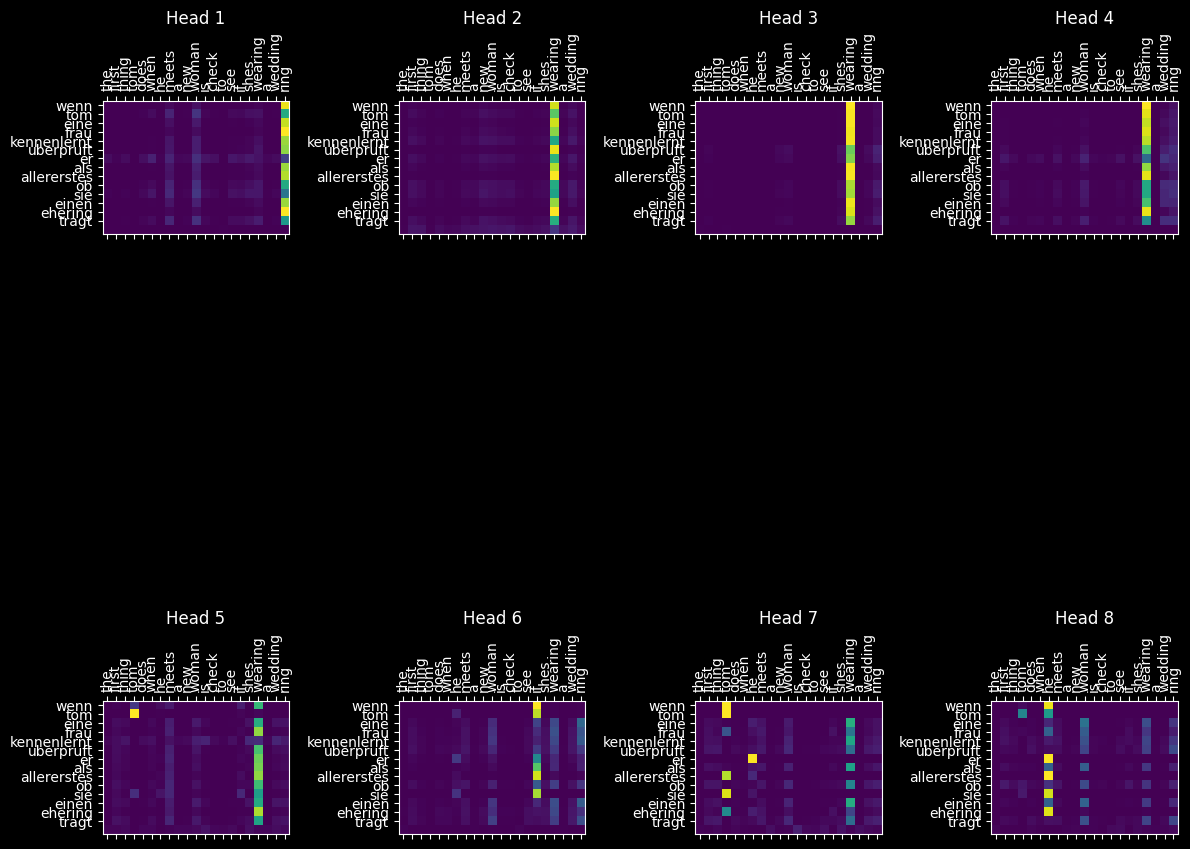

In [52]:
def show_plot(start=1, end=110, n=1,  ####sample_decoder_input[:,:-1]
             layer='decoder_layer5_block2'):
    random_integers = [random.randint(start, end) for _ in range(n)]
    for n in random_integers:
        print(n)
        sample_encoder_input = X1[n:n+1]  # Select a sample input
        sample_decoder_input = X2[n:n+1] ###[:,:-1]  # Select a corresponding target input
        print('sample_decoder_input:', sample_decoder_input)
        prediction_out = trained_transformer([sample_encoder_input, sample_decoder_input], training=False)
        print('prediction_out:', prediction_out.shape)
        predicted_id = tf.argmax(prediction_out, axis=-1)
        print('predicted_id:', predicted_id.numpy())
        print('predicted label:', y[n:n+1])
        # layer = list(transformer_weights.keys())[-1]
        attention_weights_n = trained_transformer.decoder.dec_layers[-1].last_attn_scores
        attention_weights_n = tf.squeeze(attention_weights_n, axis=0)
        print('attn_scores: ' , attention_weights_n.shape)
        plot_attention_weights(sample_encoder_input, sample_decoder_input, attention_weights_n)
show_plot(n=1)

###  display plots

100
sample_decoder_input: [[   1    6   41  239   70    4  138  163  307    6   14   50  227 1468
    13 1469 1470 1471   24   84  344  199    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]]
prediction_out: (1, 76, 2772)
predicted_id: [[   6   41  239   70    4  138  163  307    6   14   50  227 1468   13
  1469 1470 1471   24   84  344  199    2    4    4    4    4    4    4
     4    4    4    4    4    4    4    4    4    4    4    4    4    4
     2    2    2    2    2    2    2    2    2    2    2    2    2    2
     2    2    2    2    2    2    2    2    2    2    2    2    2    2
     2    2    2    2    2    2]]
predicted label: [[   6   41  239   70    4  138  163  307    6   14   50  227 1468   13
  1469 1470 1471   24   84  344  199    2    0    0  

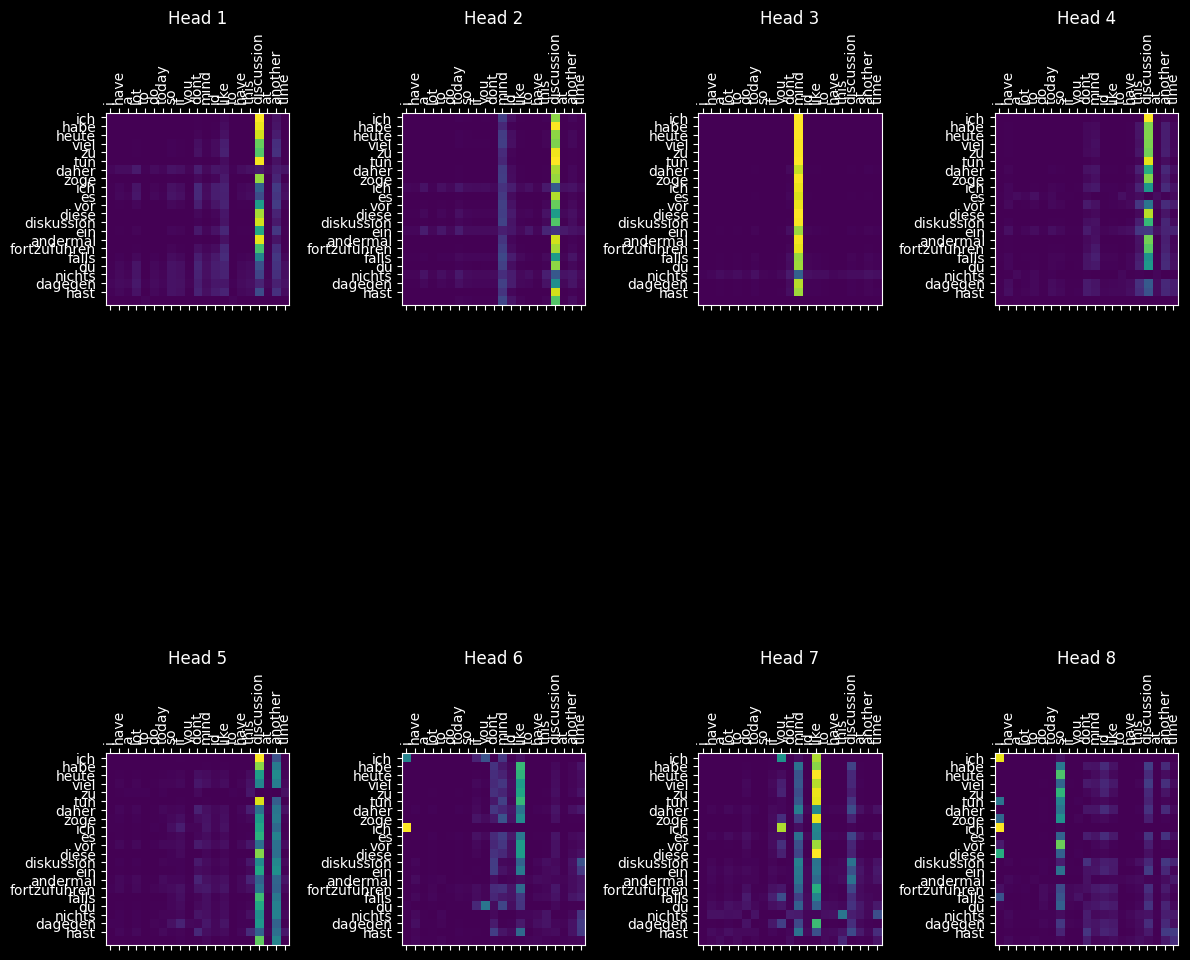

In [53]:
show_plot(n=1, start=1, end=999)

# Translator

In [54]:
input_raw_text = lang1_tokenizer.sequences_to_texts(X1[0:1])[0]
print('input_raw_text:', input_raw_text)
label = lang2_tokenizer.sequences_to_texts(y[0:1])[0]
print('label:', label)

input_raw_text: corn yields in the us have increased fivefold over the past seventy years thanks to advances in agricultural technology
label: dank fortschritten in der agrartechnik hat sich die maisernte in den vereinigten staaten in den letzten siebzig jahren verfunffacht eos


### Translator Function

In [55]:
class Translator(tf.Module):
    def __init__(self, lang1_tokenizer, lang2_tokenizer, transformer):
        self.lang1_tokenizer = lang1_tokenizer
        self.lang2_tokenizer = lang2_tokenizer
        self.transformer = transformer
        self.attention_weight = None

    def __call__(self, sentence, max_length=40):
        # Tokenize the input sentence
        sentence = self.tokenize_texts(sentence, self.lang1_tokenizer)
        encoder_input = tf.convert_to_tensor(sentence)
        
        # Initialize the output sequence with the start token
        start_seq = self.lang2_tokenizer.texts_to_sequences(['sos'])[0]  ### only single token
        start_seq = tf.cast(start_seq, dtype=tf.int64)
        start_seq = tf.expand_dims(start_seq, 0)  # Ensure shape is (1, 1) = > batch, single_seq
        
        # Dynamic sequence generation
        output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
        output_array = output_array.write(0, start_seq)
        for i in tf.range(max_length):
            output_seq = tf.transpose(output_array.stack(), perm=[1, 0, 2])
            output_seq = tf.reshape(output_seq, [1, -1])
            predictions = self.transformer([encoder_input, output_seq], training=False)
            
            # Select the last token from the seq_len dimension
            predicted_id = tf.argmax(predictions[:, -1, :], axis=-1)
            predicted_id = tf.expand_dims(predicted_id, 1)  # Expand dims to match shape (1, 1)
            output_array = output_array.write(i+1, predicted_id)
            
            # Check if the last predicted token is the end token
            if tf.reduce_all(predicted_id == self.lang2_tokenizer.word_index['eos']):
                break
                
        output = tf.transpose(output_array.stack())
        output = tf.reshape(output, [1, -1])  # Reshape to flatten the sequence
        # Convert token IDs back to text
        translated_sequence = self.detokenize_texts(output, self.lang2_tokenizer)
        self.attention_weights = self.transformer.decoder.dec_layers[-1].last_attn_scores
        # decoder.dec_layers[-1].last_attn_scores
        return translated_sequence

    @staticmethod
    def tokenize_texts(text, tokenizer):
        # Tokenize the text using the tokenizer's texts_to_sequences method
        tokenized_text = tokenizer.texts_to_sequences([text])
        return tf.keras.preprocessing.sequence.pad_sequences(tokenized_text, padding='post')

    @staticmethod
    def detokenize_texts(sequence, tokenizer):
        # Convert the sequence of token IDs back to text using the tokenizer's sequences_to_texts method
        text = tokenizer.sequences_to_texts(sequence.numpy().tolist())
        return text


# Assuming transformer is your Transformer model instance
translator = Translator(lang1_tokenizer, lang2_tokenizer, trained_transformer)
print('input_raw_text:', input_raw_text)
translated_text = translator(input_raw_text, max_length=50)
print(translated_text)
print('label:', label)

input_raw_text: corn yields in the us have increased fivefold over the past seventy years thanks to advances in agricultural technology


2024-03-29 18:56:52.758240: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT64 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


['sos dank fortschritten in der agrartechnik hat sich die maisernte in den vereinigten staaten in den letzten siebzig jahren verfunffacht eos']
label: dank fortschritten in der agrartechnik hat sich die maisernte in den vereinigten staaten in den letzten siebzig jahren verfunffacht eos


### Testing Translator

In [56]:
idx = 10
input_raw_text1 = lang1_tokenizer.sequences_to_texts(X1[idx:idx+1])[0]
print('input_raw_text1:', input_raw_text1)
label = lang2_tokenizer.sequences_to_texts(y[idx:idx+1])[0]
print('label:', label)
translated_text = translator(input_raw_text1, max_length=50)
print()
print(translated_text)

input_raw_text1: tom prefers to take a shower in the morning while mary prefers to take a bath just before going to bed
label: tom duscht lieber am morgen wahrend maria lieber vor dem zubettgehen badet eos

['sos tom duscht lieber am morgen wahrend maria lieber vor dem zubettgehen badet eos']


In [57]:
attention_weights_n = tf.squeeze(translator.attention_weights, axis=0)

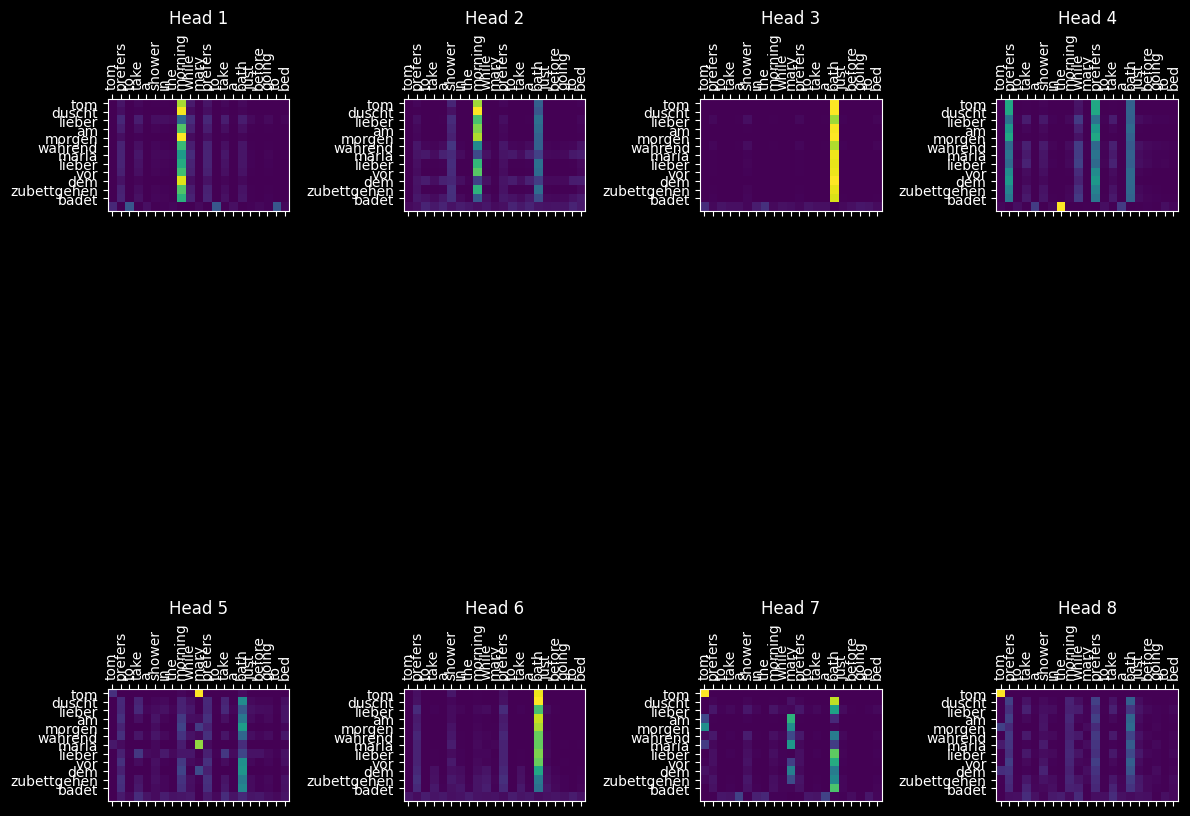

In [58]:
plot_attention_weights(X1[idx:idx+1], X2[idx:idx+1],
                           attention_weights_n)

In [59]:
lang2_tokenizer.texts_to_sequences(['eos'])

[[2]]

In [60]:
lang1_tokenizer.sequences_to_texts(X1[:1])

['corn yields in the us have increased fivefold over the past seventy years thanks to advances in agricultural technology']

In [61]:
# predictions = translator(tf.constant(X1[:1]))